In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


%matplotlib inline

In [2]:
import os

data_path = '/home/void/data/processed_files/'

files = os.listdir(data_path)
files = [file for file in files if file.endswith('.pkl')]

In [3]:
dfs = [pd.read_pickle(data_path + file) for file in files]

In [4]:
df = pd.concat(dfs)

In [226]:
#normalized_df=(df-df.min())/(df.max()-df.min())

In [5]:
df.agg(np.mean)

views           624.931022
likes             1.788804
review_count      0.117500
pic_count         9.887565
dtype: float64

In [156]:
def convert_price(string):
    return float(string[1:])

In [162]:
df['price_usd'] = df.price.apply(convert_price)

In [163]:
df.agg(np.mean)

views           617.509667
likes             1.812333
review_count      0.116000
pic_count         9.882667
price_usd        31.268650
dtype: float64

In [164]:
df.corr()

,views,likes,review_count,pic_count,price_usd
views,1.000000,0.580413,0.590580,0.058293,0.059999
likes,0.580413,1.000000,0.684010,0.135114,0.049091
review_count,0.590580,0.684010,1.000000,0.052975,0.001108
pic_count,0.058293,0.135114,0.052975,1.000000,0.089801
price_usd,0.059999,0.049091,0.001108,0.089801,1.000000


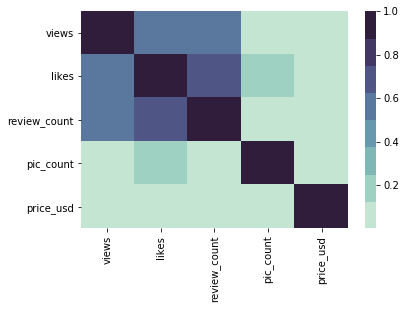

In [165]:
sns.heatmap(df.corr(), cmap=sns.cubehelix_palette(8, start=.5, rot=-.55))

In [205]:
df['tag_count'] = df['tags'].agg(len)

In [208]:
mean_price_by_num_tags = df.groupby('tag_count').agg(np.mean)['price_usd']

In [236]:
df['tag_quantiles'] = pd.cut(df['tag_count'], df['tag_count'].quantile(np.linspace(0, 1, 10)))

In [237]:
mean_price_by_tag_quantiles = df.groupby('tag_quantiles').agg(np.mean)['price_usd']

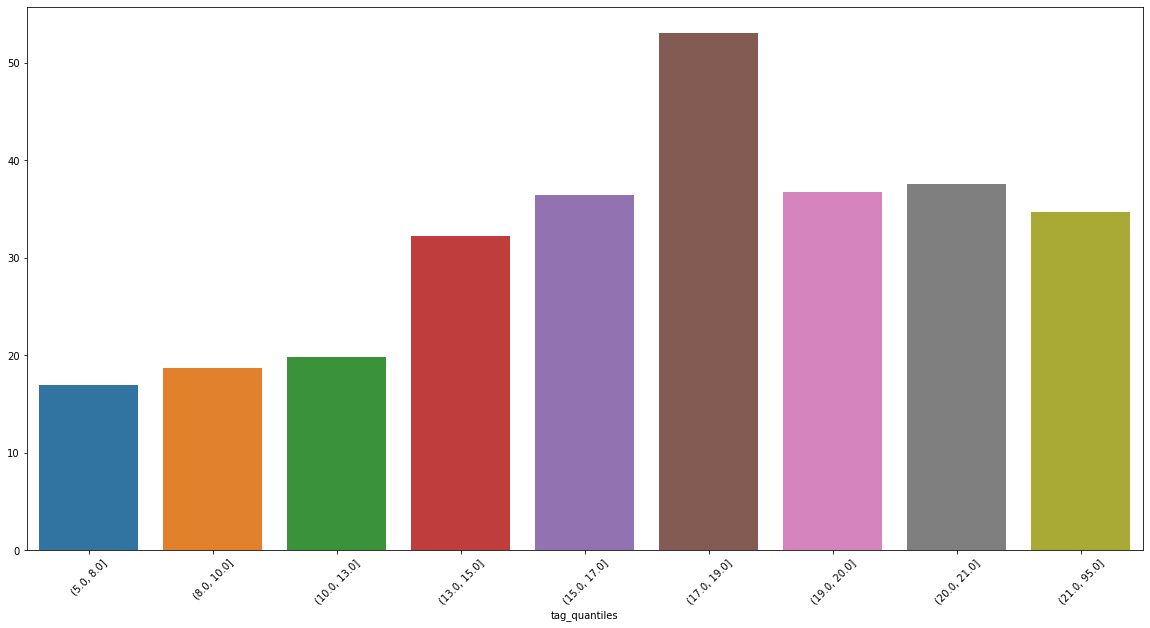

In [239]:
fig, ax = plt.subplots(figsize=(20,10))

#num_tags_mean_price = num_tags_mean_price.sort_values(ascending=False)

sns.barplot(mean_price_by_tag_quantiles.index, mean_price_by_tag_quantiles.values)
ax.set_xticklabels(mean_price_by_tag_quantiles.index, rotation=45);

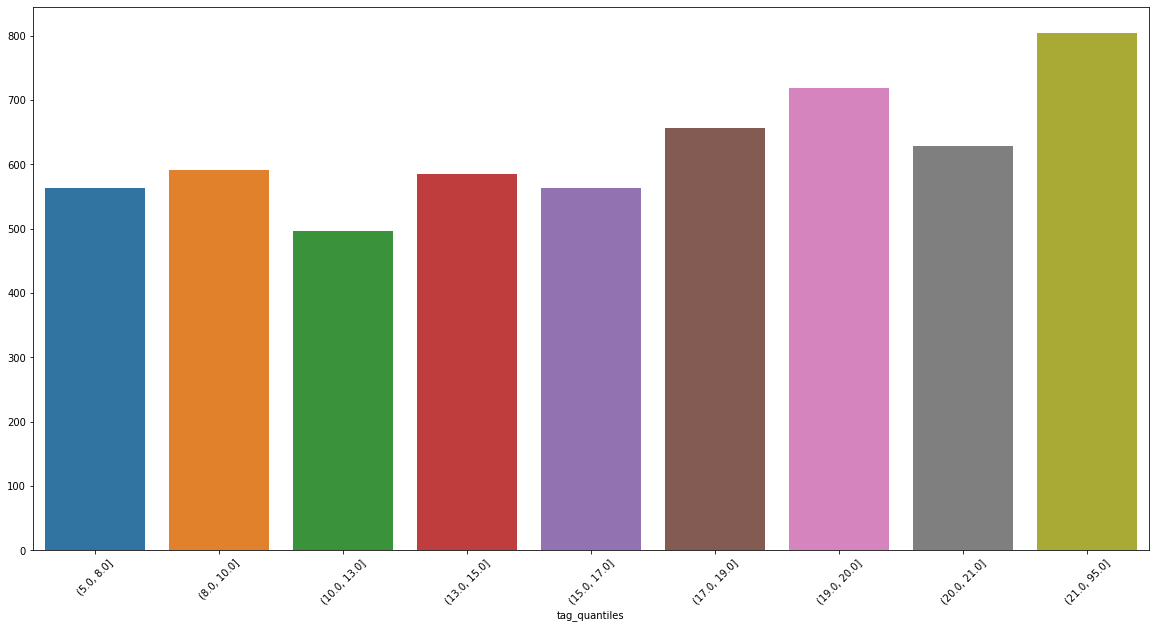

In [240]:
fig, ax = plt.subplots(figsize=(20,10))

mean_views_by_tag_quantiles = df.groupby('tag_quantiles').agg(np.mean)['views']

sns.barplot(mean_views_by_tag_quantiles.index, mean_views_by_tag_quantiles.values)
ax.set_xticklabels(mean_views_by_tag_quantiles.index, rotation=45);

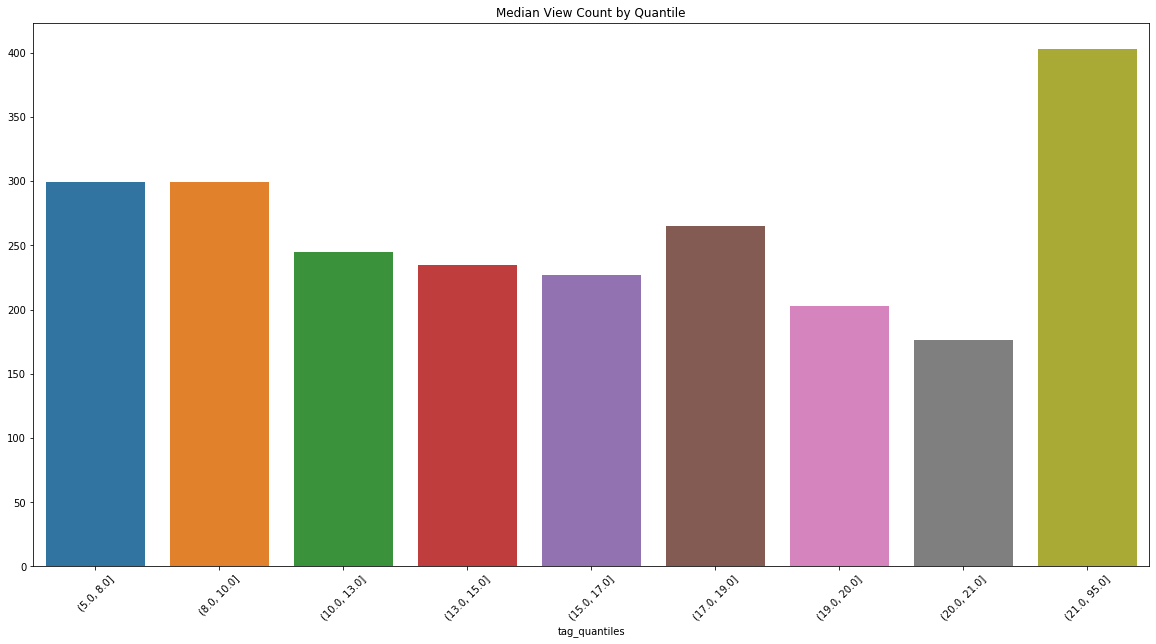

In [244]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_title('Median View Count by Quantile')

median_views_by_tag_quantiles = df.groupby('tag_quantiles').agg(np.median)['views']

sns.barplot(median_views_by_tag_quantiles.index, median_views_by_tag_quantiles.values)
ax.set_xticklabels(median_views_by_tag_quantiles.index, rotation=45);

In [213]:
df[df['tag_count'] >= ]

,modeler,modeler_response,modeler_ratings,tags,views,likes,review_count,comments,price,pic_count,model_description,model_details,price_usd,tag_bins,tag_count
654,frederictabary,"{'percent': 33, 'time': '48.0h'}","{'avg_rating': 3.1, 'num_rating': 37}","[after, bed, agence, 3d, frédéric, tabary, bed...",547,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$9.80,5,This 3D model was originally created with Sket...,"{'model_id': '186174', 'geometry': '- ', 'poly...",9.80,"(23.0, 27.5]",27
407,fabelar,"{'percent': 96, 'time': '0.3h'}","{'avg_rating': 4.9, 'num_rating': 82}","[design, seat, relax, rest, standard, material...",925,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$15.00,7,3D office chair. Vray materials and textures i...,"{'model_id': '21916', 'geometry': 'Subdivision...",15.00,"(23.0, 27.5]",27
427,Preto3d,"{'percent': 13, 'time': '48.0h'}","{'avg_rating': 5.0, 'num_rating': 3}","[office, skyscraper, traffic, tree, metro, urb...",674,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$35.00,1,3D model of a modern building.Take a look at t...,"{'model_id': '113054', 'geometry': 'Polygon me...",35.00,"(23.0, 27.5]",27
921,firdz3d,"{'percent': 83, 'time': '3.4h'}","{'avg_rating': 3.7, 'num_rating': 79}","[bulb, incandescent, lamp, lighting, globe, el...",1770,1,0,"{'authors': [], 'texts': [], 'datetimes': []}",$9.00,6,LIGHT BULB=========================- Modeled i...,"{'model_id': '60479', 'geometry': 'Polygon mes...",9.00,"(23.0, 27.5]",27
302,hum3d,"{'percent': 27, 'time': '48.0h'}","{'avg_rating': 4.7, 'num_rating': 133}","[ashley, furniture, shay, bedroom, set, bulb, ...",905,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$29.00,3,Ashley Shay Table Lamp - 3D model.This model i...,"{'model_id': '26545', 'geometry': 'Polygon mes...",29.00,"(23.0, 27.5]",27
553,fabelar,"{'percent': 96, 'time': '0.3h'}","{'avg_rating': 4.9, 'num_rating': 82}","[stadium, arena, soccer, sport, field, buildin...",1070,3,0,"{'authors': [], 'texts': [], 'datetimes': []}",$79.00,15,"Stadium level 2 lowpoly 3D model. Vray, scanli...","{'model_id': '98914', 'geometry': 'Polygon mes...",79.00,"(23.0, 27.5]",27
868,fabelar,"{'percent': 96, 'time': '0.3h'}","{'avg_rating': 4.9, 'num_rating': 82}","[audi, s 1, sportback, car, concept, prototype...",1160,1,0,"{'authors': [], 'texts': [], 'datetimes': []}",$65.00,12,"Audi S1 Sportback rigged 3D model, Standard ma...","{'model_id': '71779', 'geometry': 'Subdivision...",65.00,"(23.0, 27.5]",27
936,Preto3d,"{'percent': 13, 'time': '48.0h'}","{'avg_rating': 5.0, 'num_rating': 3}","[office, skyscraper, traffic, tree, metro, urb...",553,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$35.00,1,3D model of a modern building.Take a look at t...,"{'model_id': '113939', 'geometry': 'Polygon me...",35.00,"(23.0, 27.5]",27
123,StepanProkop,"{'percent': 64, 'time': '7.1h'}","{'avg_rating': 4.4, 'num_rating': 25}","[alco, emd, sd 7, intercity, express, track, t...",1850,2,0,"{'authors': [], 'texts': [], 'datetimes': []}",$49.00,4,"lowpoly train with the low polygon count, but ...","{'model_id': '22703', 'geometry': 'Polygon mes...",49.00,"(23.0, 27.5]",27
303,Polygonal-Miniatures,"{'percent': 95, 'time': '0.3h'}","{'avg_rating': 5.0, 'num_rating': 550}","[clothing, female, girl, woman, fashion, virtu...",944,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$19.95,5,Photorealistic ModelNormal & Texture map avail...,"{'model_id': '239840', 'geometry': 'Polygon me...",19.95,"(23.0, 27.5]",27


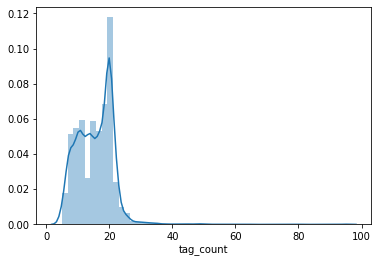

In [211]:
sns.distplot(df['tag_count']);

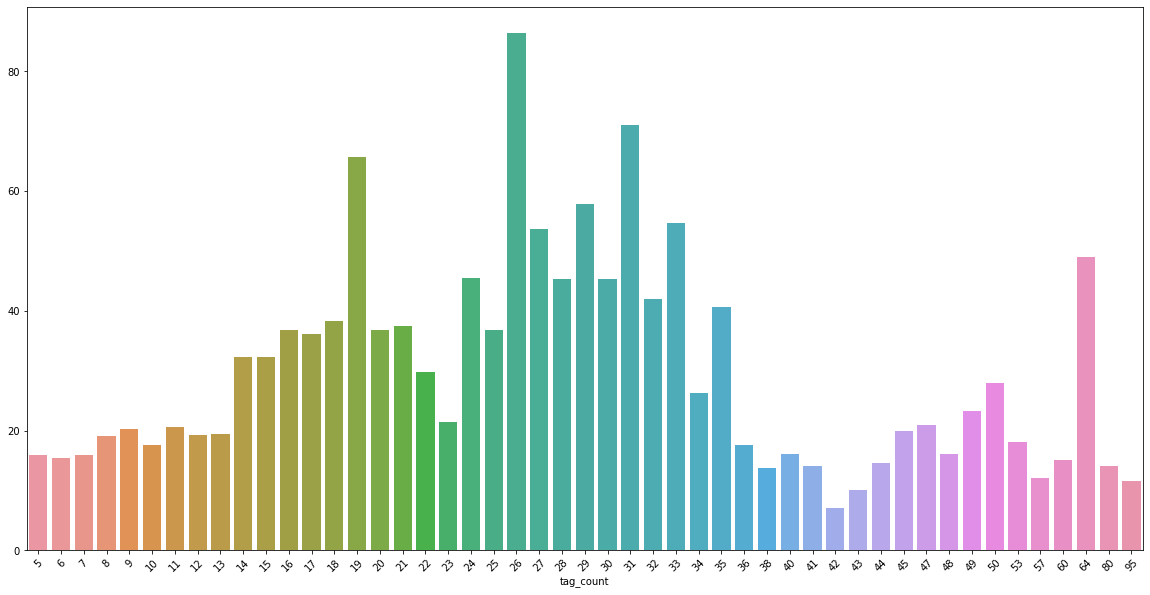

In [209]:
fig, ax = plt.subplots(figsize=(20,10))

#num_tags_mean_price = num_tags_mean_price.sort_values(ascending=False)

sns.barplot(mean_price_by_num_tags.index, mean_price_by_num_tags.values)
ax.set_xticklabels(mean_price_by_num_tags.index, rotation=45);

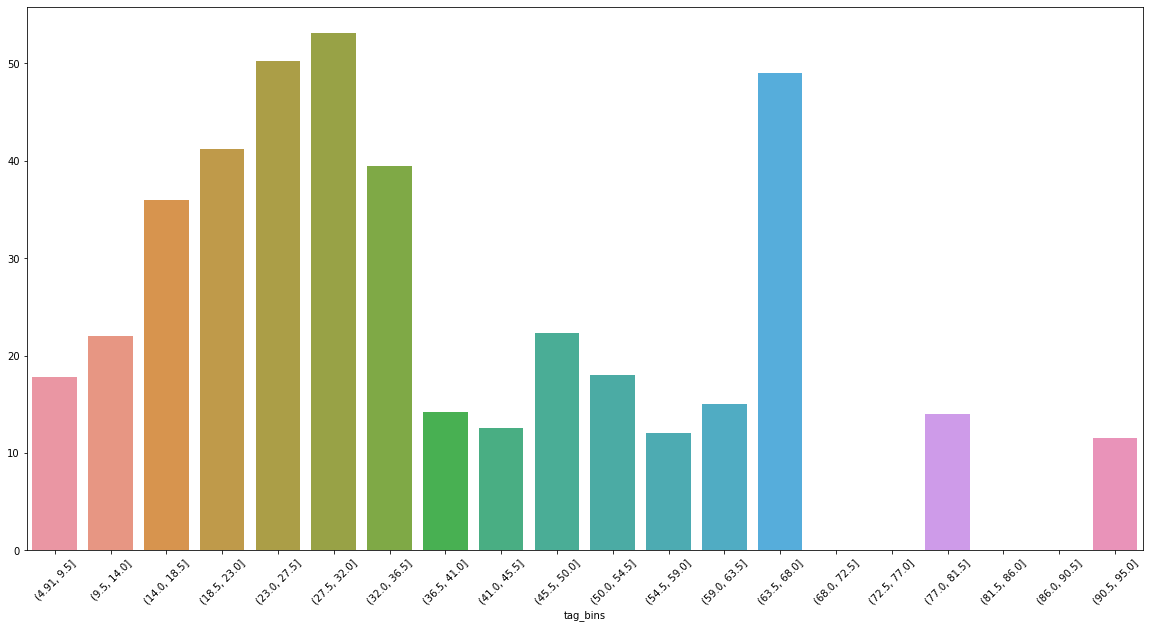

In [201]:
df['tag_bins'] = pd.cut(df['tags'].agg(len), bins=20)

num_tags_mean_price = df.groupby('tag_bins').mean()['price_usd']

fig, ax = plt.subplots(figsize=(20,10))

#num_tags_mean_price = num_tags_mean_price.sort_values(ascending=False)

sns.barplot(num_tags_mean_price.index, num_tags_mean_price.values)
ax.set_xticklabels(num_tags_mean_price.index, rotation=45);

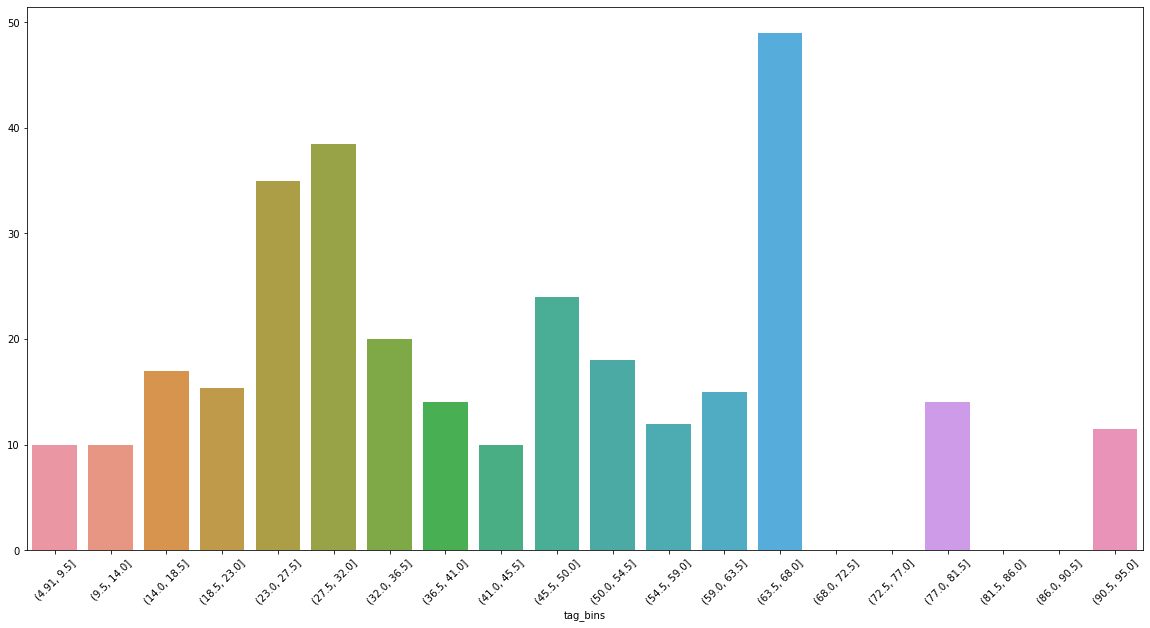

In [202]:
num_tags_median_price = df.groupby('tag_bins').median()['price_usd']

fig, ax = plt.subplots(figsize=(20,10))

#num_tags_median_price = num_tags_median_price.sort_values(ascending=False)

sns.barplot(num_tags_median_price.index, num_tags_median_price.values)
ax.set_xticklabels(num_tags_median_price.index, rotation=45);

In [100]:
groupby = df.groupby('modeler').count()

In [106]:
groupby['views'].values

array([ 1,  2,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,
        1,  3,  1,  2,  4,  4,  3,  2,  1,  2,  1,  3,  1,  1,  1,  3,  1,
        4,  1,  1,  2,  1,  1,  1,  1,  1,  2,  6,  2,  2,  1,  1,  1,  1,
        1,  1,  1,  3,  1,  1,  2,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,
        1,  1,  1,  1,  2,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  3, 34,
        1,  1,  3, 24,  1,  1,  1,  1,  2,  1,  1,  2,  1,  1,  7,  1,  1,
        1,  1,  1,  1,  1,  4,  1,  1,  4,  1,  1,  1, 13,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  1,  1,  1,  7,  1,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  1,  1,  1,  1,  1,  2,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,
        1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,
        1,  2,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  2,  1,
        1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  2,  1,  1,  1

In [107]:
np.quantile(groupby['views'].values, q=[0.25, 0.75])

array([1., 1.])

In [81]:
df['num_models'] = pd.cut(groupby.count()['tags'], bins=4)

In [82]:
df['num_models']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
995    NaN
996    NaN
997    NaN
998    NaN
999    NaN
Name: num_models, Length: 1000, dtype: category
Categories (4, interval[float64]): [(0.967, 9.25] < (9.25, 17.5] < (17.5, 25.75] < (25.75, 34.0]]

In [68]:
df.groupby('tag_bins').mean()

,views,likes,review_count,pic_count,num_tags
tag_bins,,,,,
"(4.91, 9.5]",534.754601,0.926380,0.067485,5.766871,7.447853
"(9.5, 14.0]",496.545455,1.138340,0.067194,8.249012,12.134387
"(14.0, 18.5]",461.182692,1.500000,0.067308,11.822115,16.543269
"(18.5, 23.0]",654.211594,2.031884,0.144928,12.382609,20.350725
"(23.0, 27.5]",1168.250000,0.600000,0.050000,5.900000,25.300000
"(27.5, 32.0]",2225.000000,1.285714,0.000000,7.714286,30.571429
"(32.0, 36.5]",NaN,NaN,NaN,NaN,NaN
"(36.5, 41.0]",23.000000,1.000000,0.000000,6.000000,40.000000
"(41.0, 45.5]",NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn import preprocessing

x, y = df.views, df.price_usd

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y_scaled = min_max_scaler

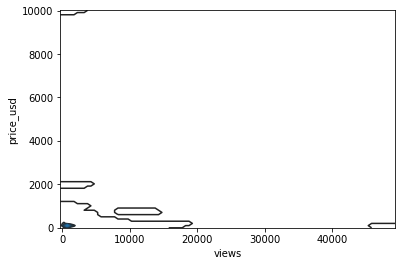

In [224]:
sns.kdeplot(df['views'], df['price_usd'])

In [ ]:
dist_df = df.loc[:, ['views']]

In [38]:
g = sns.FacetGrid(df, #the dataframe to pull from
                  row="hue", #define the column for each subplot row to be differentiated by
                  hue="hue", #define the column for each subplot color to be differentiated by
                  aspect=10, #aspect * height = width
                  height=1.5, #height of each subplot
                  palette=['#4285F4','#EA4335','#FBBC05','#34A853'] #google colors
                 )

KeyError: 'hue'

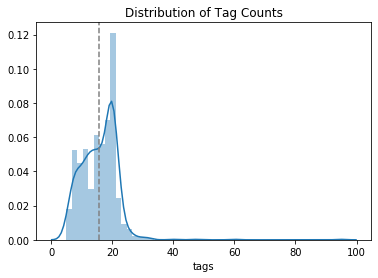

In [34]:
fig, ax = plt.subplots()

sns.distplot(df.tags.agg(len));

ax.set_title('Distribution of Tag Counts')
ax.axvline(np.mean(df.tags.agg(len)), color='gray', linestyle='--')


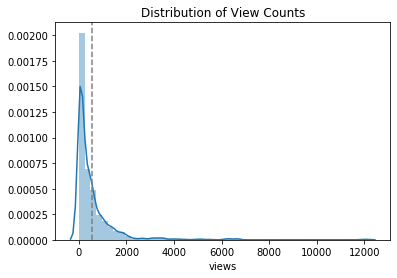

In [36]:
fig, ax = plt.subplots()

sns.distplot(df.views);

ax.set_title('Distribution of View Counts')
ax.axvline(np.mean(df.views), color='gray', linestyle='--');